In [27]:
import pyopencl as cl
import numpy as np
import pyopencl.cltypes

platforms = cl.get_platforms()

for platfrom in platforms:
    devices = platfrom.get_devices()
    print(devices)
    
int_a = cl.cltypes.int(256)
print(type(int_a))

[<pyopencl.Device 'Oclgrind Simulator' on 'Oclgrind' at 0x55d1a05203b0>]
[<pyopencl.Device 'NVIDIA GeForce RTX 4070 Ti' on 'NVIDIA CUDA' at 0x55d1a0523800>]
[<pyopencl.Device 'pthread-AMD Ryzen 9 7950X 16-Core Processor' on 'Portable Computing Language' at 0x55d1a0524f70>]
<class 'numpy.int32'>


In [26]:
import pyopencl as cl
import numpy as np

a_np = np.random.rand(50000).astype(np.float32)
b_np = np.random.rand(50000).astype(np.float32)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

prg = cl.Program(ctx, """
__kernel void sum(
    __global const float *a_g, __global const float *b_g, __global float *res_g)
{
  int gid = get_global_id(0);
  res_g[gid] = a_g[gid] + b_g[gid];
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
knl = prg.sum  # Use this Kernel object for repeated calls
knl(queue, a_np.shape, None, a_g, b_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)
print(res_g.size)

200000


In [31]:
from PIL import Image
import numpy as np

lss = Image.open('./cat.bmp')
arr = np.array(lss.getdata(), np.int32)

val_arr = [x for x in range(0, 256)]
print(val_arr)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

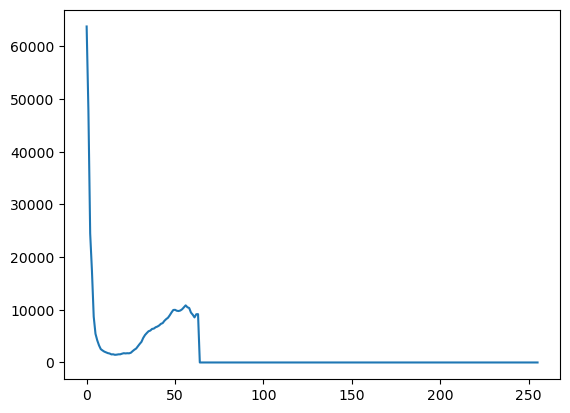

In [36]:
import pyopencl as cl
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

lss = Image.open('./cat.bmp')
arr = np.array(lss.getdata(), np.int32)

platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.ALL,
        properties=[(cl.context_properties.PLATFORM, platforms[2])])
#ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
arr_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=arr)

prg = cl.Program(ctx, """
#define HIST_BINS 256

__kernel void histogram(__global int *data, int  numData, __global int *histogram) {

  __local int localHistorgram[HIST_BINS];
  int lid = get_local_id(0);
  int gid = get_global_id(0);
  
  /* Initialize local histogram to zero */
  for (int i = lid; i < HIST_BINS; i += get_local_size(0)) {
    localHistorgram[i] = 0;
  }
  
  /* Wait nutil all work-items within
   * the work-group have completed their stores */
  barrier(CLK_LOCAL_MEM_FENCE);
  
  /* Compute local histogram */
  for (int i = gid; i < numData; i += get_global_size(0)) {
    atomic_add(&localHistorgram[data[i]], 1);
  }
  
  /* Wait nutil all work-items within
   * the work-group have completed their stores */
  barrier(CLK_LOCAL_MEM_FENCE);
  
  /* Write the local histogram out to
   * the global histogram */
  for (int i = lid; i < HIST_BINS; i += get_global_size(0)) {
    atomic_add(&histogram[i], localHistorgram[i]);
  }
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, 256 * 4)
cl.enqueue_fill_buffer(queue, res_g, cl.cltypes.int(0), 0, 256 * 4)

knl = prg.histogram 
knl(queue, (1024,), (64,), arr_g, cl.cltypes.int(arr.size), res_g)

res_np = np.empty(256, dtype=cl.cltypes.int)
#print(type(res_np))
cl.enqueue_copy(queue, res_np, res_g)

val_arr = [x for x in range(0, 256)]

plt.plot(val_arr, res_np)

In [ ]:
from PIL import Image

display(Image.open('cat.bmp'))

In [2]:
!pwd

/home/qlgr/program-dev/dev-root/opencl/python/ch04


In [ ]:
import pyopencl as cl
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

lss = Image.open('./cat.bmp')
arr = np.array(lss.getdata(), np.float32)

platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.ALL,
        properties=[(cl.context_properties.PLATFORM, platforms[2])])

queue = cl.CommandQueue(ctx)


mf = cl.mem_flags
arr_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=arr)

prg = cl.Program(ctx, """
__constant sampler_t sampler = 
  CLK_NORMALIZED_COORDS_FALSE |
  CLK_FILTER_LINEAR           |
  CLK_ADDRESS_CLAMP;

__kernel
void rotation(
  __read_only image2d_t inputImage,
  __write_only image2d_t outputImage,
  int imageWidth,
  int imageHeight,
  float theta)
{
  /* Get global ID for ouput coordinates */
  int x = get_global_id(0);
  int y = get_global_id(1);

  /* Compute image center */
  float x0 = imageWidth / 2.0f;
  float y0 = imageHeight / 2.0f;

  /* Compute the work-item's location relative
   * to the image center */
  int xprime = x - x0;
  int yprime = y - y0;

  /* Compute sine and cosine */
  float sinTheta = sin(theta);
  float cosTheta = cos(theta);

  /* Compute the input location */
  float2 readCoord;
  readCoord.x = xprime * cosTheta - yprime * sinTheta + x0;
  readCoord.y = xprime * sinTheta + yprime * cosTheta + y0;

//   /* Read the input image */
//   float value;
//   value = read_imagef(inputImage, sampler, readCoord).x;
//
//   /* Write the output image */
//   write_imagef(outputImage, (int2)(x, y), (float4)(value, 0.f, 0.f, 0.f));

   /* Read the input image */
  float4 value;
  value = read_imagef(inputImage, sampler, readCoord);

  /* Write the output image */
  write_imagef(outputImage, (int2)(x, y), value);
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, 256 * 4)
cl.enqueue_fill_buffer(queue, res_g, cl.cltypes.int(0), 0, 256 * 4)

knl = prg.histogram 
knl(queue, (1024,), (64,), arr_g, cl.cltypes.int(arr.size), res_g)

res_np = np.empty(256, dtype=cl.cltypes.int)
#print(type(res_np))
cl.enqueue_copy(queue, res_np, res_g)

val_arr = [x for x in range(0, 256)]

plt.plot(val_arr, res_np)